# Importing and installing pre-requisite libraries

In [2]:
!pip install -q segmentation_models
!pip install -q pycocotools

In [4]:
import numpy as np
import random
from random import sample
import tensorflow as tf
from skimage import color
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,concatenate
from keras.models import Model
import pandas as pd
from pycocotools.coco import COCO
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segmentation_models as sm
sm.set_framework('tf.keras')
tf.random.set_seed(42)
from tensorflow.keras.utils import to_categorical

Segmentation Models: using `keras` framework.


# Downloading and unzipping Data
This was useful in a colab environment but not required after shifting to a kaggle environment since kaggle already hosts the dataset that can be directly imported.

In [ ]:
#!wget http://images.cocodataset.org/zips/train2017.zip
#!wget http://images.cocodataset.org/zips/val2017.zip
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#!unzip annotations_trainval2017.zip
#!unzip train2017.zip
#!unzip val2017.zip

In [5]:
dir="/kaggle/input/coco-2017-dataset/coco2017/"
coco=COCO(dir+'annotations/instances_train2017.json')# coco objects that assist us in accessing the .json file
coco_val=COCO(dir+'annotations/instances_val2017.json')
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)#dictionary of class ids and their labels

loading annotations into memory...
Done (t=22.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [6]:
id_to_label=dict()#dictionary that converts id to label name
for item in cats:
  id_to_label[item['id']]=item['name']
label_to_id=dict(zip(id_to_label.values(),id_to_label.keys()))#dictionary that converts label name to id

In [7]:
def get_image_path(id,mode):
  '''assistant function that returns the path of an image from the training dataset using its image ID'''
  if mode=='train':
    return dir+'train2017/'+str(id).zfill(12)+'.jpg'
  if mode=='val':
    return dir+'val2017/'+str(id).zfill(12)+'.jpg'

We will declare a subset list `selected_classes` containing names of the classes that we have been assigned to detect in this project, against all the available 80 classes in the COCO dataset.

In [8]:
selected_classes=['person', 'chair', 'car', 'dining table', 'cup', 'bottle', 'bowl', 'handbag', 'truck', 'bench', 'backpack', 'book', 'cell phone', 'sink', 
                  'clock', 'tv', 'potted plant', 'couch', 'dog', 'knife', 'sports ball', 'traffic light', 'cat', 'umbrella', 'bus']
selected_classes_ids=[label_to_id[class_name] for class_name in selected_classes]

# Sanity Check
We will look at a random picture and its annotations from our training data.

In [16]:
def generate_mask(image_id,selected_classes,coco):
  '''
  this function generates a single channel mask of the image id provided to it.
  it filters the mask by the selected_classes list and returns a numpy array.
  '''
  imgdic=coco.loadImgs(image_id)[0]
  annIds = coco.getAnnIds(imgIds=image_id)
  anns = coco.loadAnns(annIds)
  mask = np.zeros((imgdic['height'],imgdic['width']))
  for i in range(len(anns)):
      className = id_to_label[anns[i]['category_id']]
      if className not in selected_classes:
        continue
      pixel_value = selected_classes.index(className)+1
      mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
  return mask

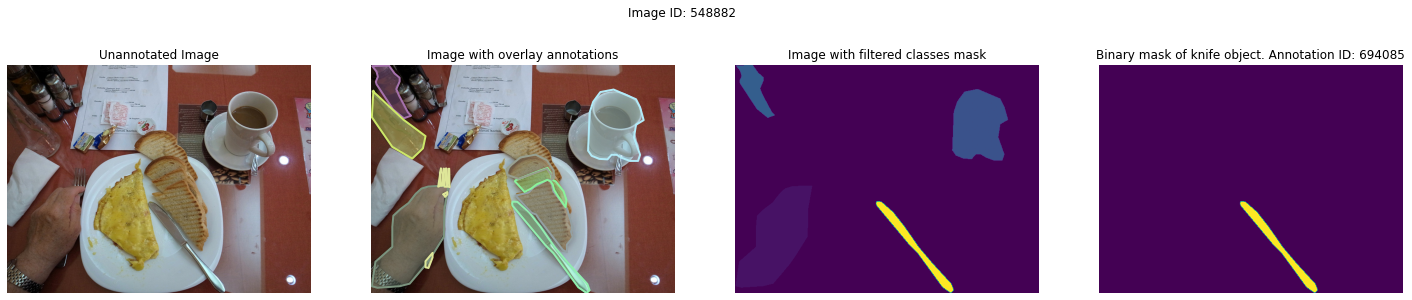

In [17]:
id=548882 #random image ID 
fig=plt.figure(figsize=(25,5))
fig.suptitle(f'Image ID: {id}')
ax1=fig.add_subplot(1,4,1)
plt.title(f'Unannotated Image')
ax1.axis('off')
img=Image.open(get_image_path(id,'train'))
ax1.imshow(img)
ax2=fig.add_subplot(1,4,2)
plt.title(f'Image with overlay annotations')
ax2.axis('off')
ax2.imshow(img)
annIds=coco.getAnnIds(imgIds=id)
coco.showAnns(coco.loadAnns(annIds))
ax3=fig.add_subplot(1,4,3)
plt.title(f'Image with filtered classes mask')
ax3.axis('off')
mask=generate_mask(id,selected_classes,coco)
ax3.imshow(mask)
ax4=fig.add_subplot(1,4,4)
ax4.axis('off')
mask=coco.annToMask(coco.loadAnns(annIds[2])[0])
plt.title(f'Binary mask of knife object. Annotation ID: {annIds[2]}')
ax4.imshow(mask)
plt.show()

# Pre-processing

In [18]:
def get_image_ids(selected_classes,coco):
  '''this function returns a list of all possible combinations of images with selected class IDs from the provided coco object'''
  selected_classes_ids=[label_to_id[label] for label in selected_classes]
  images_ids=set()
  for class_id in selected_classes_ids:
    images_per_class=coco.getImgIds(catIds=class_id)
    for image_id in images_per_class:
      images_ids.add(image_id)
  return list(images_ids)

In [19]:
images_ids=get_image_ids(selected_classes,coco)
print(f'Number of images with selected classes = {len(images_ids)}')

Number of images with selected classes = 95037


Since this is a very large number of images, we will only use $60\%$ of the images to train our Semantic Segmentation Network.

In [20]:
images_ids=sample(images_ids,int(0.6*len(images_ids)))
print(f'Number of images with selected classes after 60% sampling = {len(images_ids)}')

Number of images with selected classes after 60% sampling = 57022


Similarly, we will also generate a list of image ids from the validation set.

In [21]:
val_images_ids=get_image_ids(selected_classes,coco_val)
print(f'Number of validation images with selected classes = {len(val_images_ids)}')

Number of validation images with selected classes = 4027


In [22]:
def dataGeneratorCoco(image_ids, coco,mode,input_image_size=(224,224,3), batch_size=64):
  '''
  This function creates numpy array batches of tuples of resized normalized images and their masks generated from the COCO object passed to it.
  
  image_ids: list of image ids that need to be imported
  coco: coco object that will be used to access the image annotations and create masks.
  mode: 'train' or 'val' for training and validation sets respectively.
  input_image_size: dimensions that each imported image needs to be rescaled to.
  
  this function returns a tuple of two numpy arrays in the format:
  (batch_images,batch_masks) where 
  batch_images is a numpy array of dimensions (batch_size , input_image_size[0], input_image_size[1],input_image_size[2]) and
  batch_masks is a numpy array of dimensions (batch_size , input_image_size[0], input_image_size[1] , len(selected_classes)+1)
  
  the +1 in the last dimension of mask is added to create the unlabelled background mask.
  '''
  pointer = 0
  while(True):
    batch_img = np.zeros((batch_size, input_image_size[0], input_image_size[1], input_image_size[2]))#array of images in the whole batch
    batch_mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], len(selected_classes_ids)+1)).astype('float')#array of masks in the whole batch
    for i in range(pointer, pointer+batch_size): #initially from 0 to batch_size, when pointer = 0
      imgId=image_ids[i]
      img=Image.open(get_image_path(imgId,mode))
      numpydata=cv2.resize(np.asarray(img),(input_image_size[1],input_image_size[0]))#resizing image to input size provided
      if numpydata.shape!=input_image_size:#discarding all non-RGB images since there were less than 200 of them in the dataset
        continue
      #creating mask
      fmask=np.zeros((input_image_size[0], input_image_size[1],len(selected_classes_ids)+1))
      layer_no=0
      for class_id in selected_classes_ids:
        annotations_per_class=coco.loadAnns(coco.getAnnIds(imgIds=imgId,catIds=class_id))#loading all annotations for the current class_id
        for annot in annotations_per_class:#building one mask for annotations in a single class
          fmask[:,:,layer_no]+=cv2.resize(coco.annToMask(annot),(input_image_size[1], input_image_size[0]))
        fmask[:,:,layer_no][fmask[:,:,layer_no]>=0.5]=1#replacing all overlapping masks with value 1 (essentially concatenating all masks of a class together)
        fmask[:,:,layer_no][fmask[:,:,layer_no]<0.5]=0#ensuring all non activated pixels are 0
        layer_no+=1             
      #creating unlabelled (background) mask layer
      all_recognised_objects=np.maximum.reduce(fmask,axis=2)
      fmask[:,:,-1][all_recognised_objects==0]=1
      # Add to respective batch sized arrays
      batch_img[i-pointer] = numpydata/255.0
      batch_mask[i-pointer] = fmask
    pointer+=batch_size
    if(pointer + batch_size >=len(image_ids)):
        pointer=0
        random.shuffle(image_ids)
    yield batch_img, batch_mask

# The primary challenge with this dataset.
Naive attempts to load the coco dataset into the RAM resulted in the runtime dying due to too much data being loaded into the runtime memory.

My initial solution to the problem was using the `dataGeneratorCoco` generator function inside the `model.fit()` training call. The function would yield readymade batches of data to the network to train on, which would then be discarded from the RAM to free up space for the next batch. Since we were training on almost $60K$ images, with a batch_size of $64$, the function would be called $889$ times over a single epoch, where it would make several (obtaining both images and masks for all annotations per image) read requests from the disk via COCO's assistant `pycocotools` API. 

While this method was functional, it resulted in a single epoch time of almost **$50:00$ mins**, as tensorflow waited for all the masks to be generated sequentially. To parallelize and optimize this pipeline, I amortized my data pre-processing cost by creating a kaggle hosted dataset of pre-processed `.npy` files. This dataset contained $889$ batch files each containing $64$ RGB images in a numpy array of shape $(64,224,224,3)$. The dataset also hosted the corresponding $889$ batch mask files each containing $64$ label encoded masks in a numpy array of shape $(64,224,224,1)$.

With this optimization, the epoch training time was reduced to a mere **$15:00$ mins** as tensorflow only had to explode the masks (optimized further by using `keras.utils.to_categorical()` function instead of a `for` loop) to their binary encoded counterparts $(64,224,224,1)-->(64,224,224,26)$ before training the network.

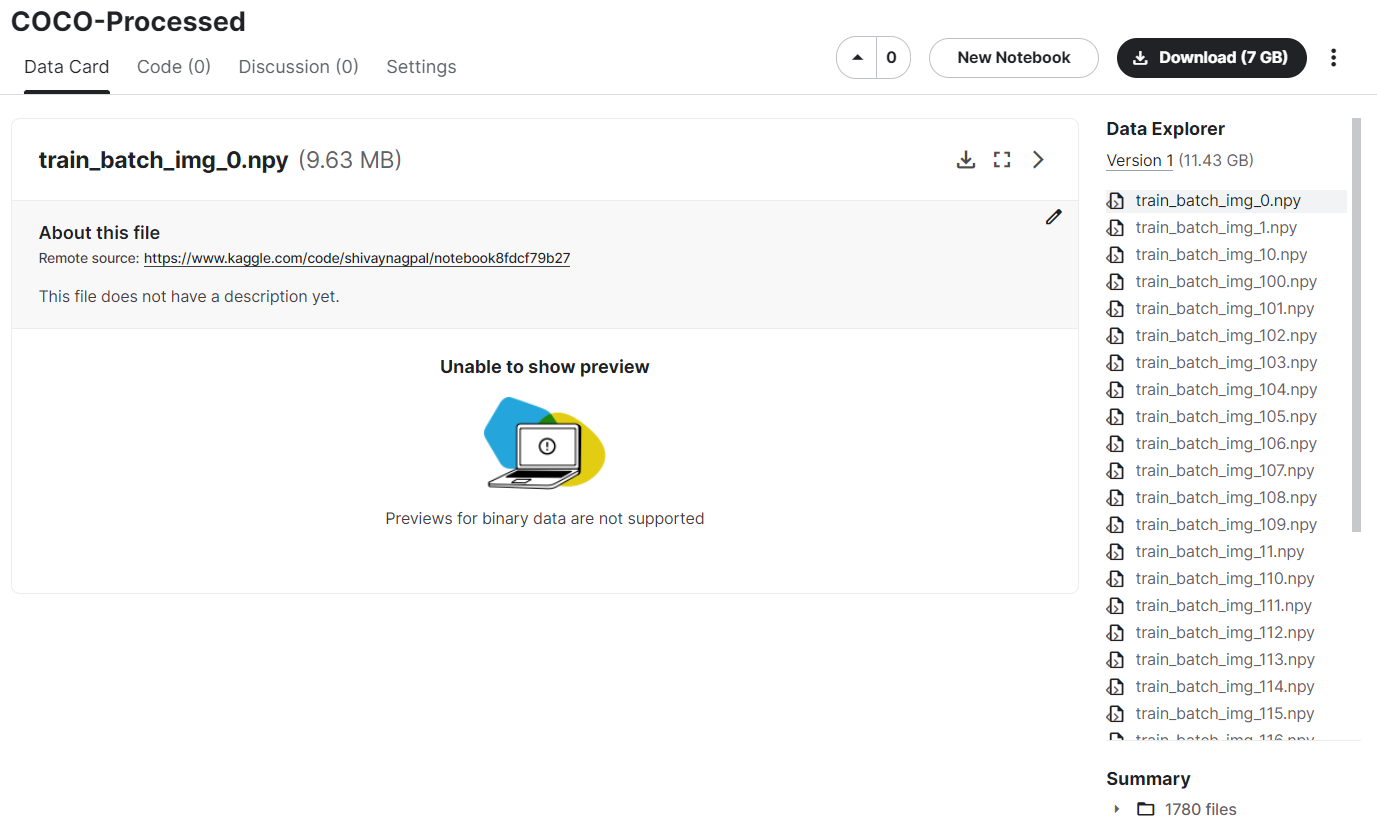
*screenshot of the private dataset hosted on Kaggle*

In [22]:
processed_dir='/kaggle/input/coco-processed'
def train_batch_fetcher():
    '''this function grabs the pre-processed numpy arrays from my private kaggle dataset and yields a tuple of images and one-hot encoded masks'''
    i=0
    while i<=889:
        batch_img=np.load(processed_dir+f'/train_batch_img_{i}.npy')/255.0
        batch_msk=np.load(processed_dir+f'/train_batch_msk_{i}.npy')
        batch_msk=to_categorical(batch_msk,26)#converting label mask to one hot encoded mask
        yield batch_img,batch_msk
        i+=1
        if i>=890: i=0

# Modelling: Approach
Image Source: [Stanford](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)<br>
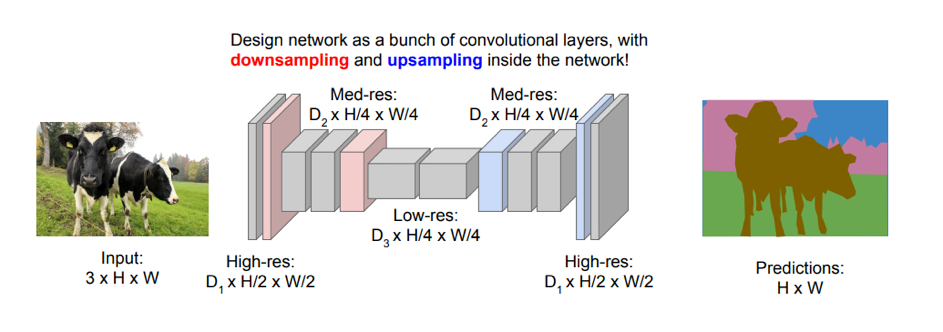

# Creating our model
We will first create a very simple encoder-decoder fully convolutional network. We will use Jaccard loss as our loss and IoU and Precision as our metrics. 

Jaccard loss is closely associated with the IoU (it is also referred to as IoU loss)

In [24]:
input_img = Input(shape = (224,224,3))
def encoder_decoder(input_img):
    #encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #h x w x 16
    conv1b = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1) #h x w x 16
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)#h/2 x w/2 x 16
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)#h/2 x w/2 x 64
    conv2b= Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)#h/2 x w/2 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)#h/4 x w/4 x 64
    
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) #h/4 x w/4 x 128
    conv3b = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) #h/4 x w/4 x 128
    #decoder
    up1 = UpSampling2D((2,2))(conv3)#h/2 x w/2 x 128
    #concat1=concatenate([up1,conv2b])#h/2 x w/2 x 160 #skipped since we will use a unet later in the notebook
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)# h/2 x w/2 x 64
    conv4b=Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)# h/2 x w/2 x 64
    up2 =  UpSampling2D((2,2))(conv4b)# h x w x 32
    #concat2=concatenate([up2,conv1b])# h x w x 48 
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)# h x w x 64
    conv5b = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)# h x w x 32
    decoded = Conv2D(len(selected_classes_ids)+1, (1, 1), activation='softmax', padding='same')(conv5b) # h x w x 26
    return decoded

In [ ]:
model=Model(input_img,encoder_decoder(input_img))
model.compile(loss=sm.losses.jaccard_loss,metrics=[sm.metrics.iou_score,sm.metrics.precision],optimizer='adam')

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      9280      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0     

As we can observe, there are are almost $300K$ paramters in this network. We will now train it over $10$ epochs.<br>
*The epoch wise losses and other metrics have been plotted later. Verbose outputs were cleared duting multiple sessions of the notebook.*

In [ ]:
history1=model.fit(train_batch_fetcher(),steps_per_epoch=889,epochs=10)
model.save_weights('encoder_decoder.h5')#preserivng weights
history1=pd.DataFrame(history1.history)

# Model Analysis

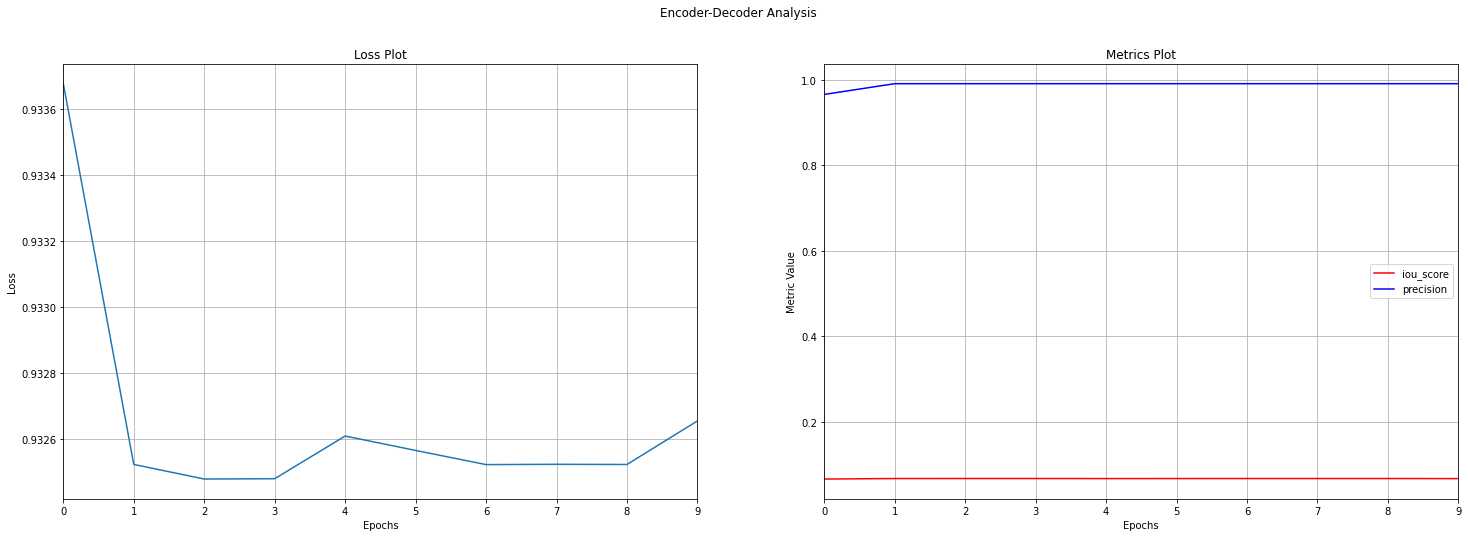

In [38]:
fig, axes = plt.subplots(ncols=2)
fig.suptitle('Encoder-Decoder Analysis')
fig.set_figwidth(25)
fig.set_figheight(8)
history1['loss'].plot(ax=axes[0],xlim=[0,9],grid=True,title="Loss Plot",xlabel="Epochs",ylabel="Loss");
history1[['iou_score','precision']].plot(ax=axes[1],xlim=[0,9],grid=True,title="Metrics Plot",xlabel="Epochs",ylabel="Metric Value",style=['r','b']);

We can observe that the jaccard loss flatlined after the first epoch and then also started increasing in the later epochs. This is because the layers and filters that we have used are insufficient considering the scale of the problem.

Additionally, while the number of epochs we trained this model is low, it is sufficient to conclude that jaccard loss alone can be further improved by adding another loss to it to optimise our model.

Further, we can also observe how the extremely high precision does not translate to a high IoU since we can achieve high precision **(and mean pixel accuracy)** just by predicting all pixels as the background class, since a majority of the pixels belong to the background class in every image. <br>
**Hence, Mean pixel accuracy and precison are not reliable metrics for semantic segmentation.**

In [24]:
batch_size=64
model.evaluate(dataGeneratorCoco(val_images_ids,coco_val,'val',batch_size=batch_size),steps=len(val_images_ids)//batch_size)

62/62 [==============================] - 243s 4s/step - loss: 0.9455 - iou_score: 0.0545 - precision: 0.9907


[0.9454541206359863, 0.05454597994685173, 0.9906502366065979]

The model achieved a low IoU score of **$0.0545$** on the validation set and a extremely high precision of **$0.9907$**

Since this model did not achieve a high IoU, we will train a new U-net encoder-decoder network with skip connections.

*sample masks generated by model are available in the report located at the end of this notebook*

# U-Net Architecture
Now, we will employ a U-Net architecture with skip connections using a `resnet18` encoder as the backbone. We will also employ transfer learning in this approach by initializing our encoder with weights obtained by training the encoder backbone on the `imagenet` dataset.

This was facilitated by the `segmentation_models` library. 

The backbone `resnet18` encoder is visualised below [(Source)](https://www.researchgate.net/publication/336642248_A_Deep_Learning_Approach_for_Automated_Diagnosis_and_Multi-Class_Classification_of_Alzheimer's_Disease_Stages_Using_Resting-State_fMRI_and_Residual_Neural_Networks):

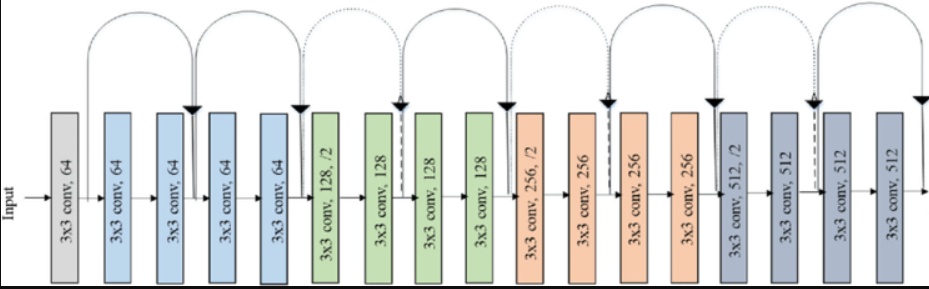

In [27]:
model_resnet_backbone = sm.Unet('resnet18', input_shape =(224,224,3),classes=len(selected_classes_ids)+1, 
                                activation='softmax',encoder_weights='imagenet')

44933120/44920640 [==============================] - 1s 0us/step


In [28]:
model_resnet_backbone.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

This network is significantly larger compared to our previous network. As we can observe, there are almost $14M$ parameters, out of which the encoder parameters are initialised with pre-trained weights while the decoder's weights are initialized with weights using `'glorot_uniform'` by default, which initializes them by sampling from the uniform distribution.

Additionally, we changed our loss function to a sum of categorical focal loss and jaccard loss (available from the `segmentation_models` library). This was done as the focal Tversky loss was found to be a good loss function [(Source)](https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5) for datasets with a lot of class imbalance, which is the case for COCO as the `person` (and `unlabelled`) classes have a significantly high presence compared to all other classes in the dataset.

Our model was trained for a total of $48$ epochs across $2$ runtimes for almost $12$ hours using kaggle jupyter environment accelerated with a **T4 x2 GPU**<br> *I accidently lost the loss and metric logging information for the first $8$ epochs because of getting disconnected from the runtime. The information for the proceding 40 epochs has been presented in the model analysis.*

In [29]:
model_resnet_backbone.load_weights('/kaggle/input/unet-weights/u_net_weights.h5')#loading weights from the model trained for the first 8 epochs.
model_resnet_backbone.compile(optimizer='adam', loss=sm.losses.categorical_focal_jaccard_loss,metrics=[sm.metrics.iou_score,sm.metrics.precision])
history2=model_resnet_backbone.fit(train_batch_fetcher(),steps_per_epoch=889,epochs=40,verbose=1)

In [ ]:
history2=pd.DataFrame(history2.history)#creating epoch logging dataframe
model_resnet_backbone.save_weights('u_net_weights_2.h5')#preserving weights 

# Model Analysis

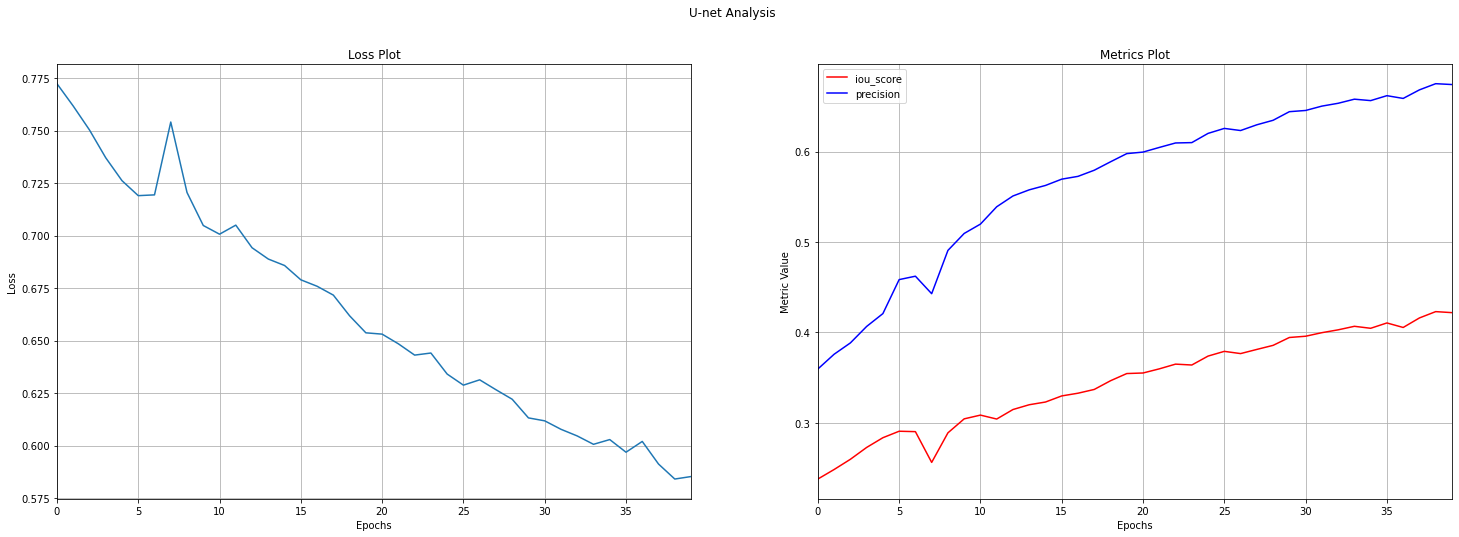

In [39]:
fig, axes = plt.subplots(ncols=2)
fig.suptitle('U-net Analysis')
fig.set_figwidth(25)
fig.set_figheight(8)
history2['loss'].plot(ax=axes[0],xlim=[0,39],grid=True,title="Loss Plot",xlabel="Epochs",ylabel="Loss");
history2[['iou_score','precision']].plot(ax=axes[1],xlim=[0,39],grid=True,title="Metrics Plot",xlabel="Epochs",ylabel="Metric Value",style=['r','b']);

As we can observe, this model was successful in decreasing its combined loss during its training. We also achieved a training IoU of $0.421895$ and a training precision of $0.674190$, as reflected in the training plots above.

In [21]:
model_resnet_backbone.evaluate(dataGeneratorCoco(val_images_ids, coco_val,'val',input_image_size=(224,224,3), batch_size=64),steps=62)

62/62 [==============================] - 217s 4s/step - loss: 0.8024 - iou_score: 0.2112 - precision: 0.4958


[0.8023546934127808, 0.21123535931110382, 0.4957660138607025]

The final validation IoU stood at $0.2112$ and the precision stood at $0.4957$. Since there is a wide gap between the training and validation IoU, there is a possibilty that our network is overfitted to the training data. Further, overfitting is not the only explanation for the discrepancy as the lag might have arisen due to the nature of our problem.<br>
*Sample masks are generated in the report.*

# Report
Since the model architecture, the training process and the evaluation results for each model have already been discussed, we will now just visualise the maks that both our models generated on images from the validation set (previously unseen by network).

## Sample masks
We will first sample $10$ random images from our validation dataset.

In [89]:
report_val_ids=sample(val_images_ids,10)#randomly sampling 10 images from filtered validation set
obj=dataGeneratorCoco(report_val_ids, coco_val,'val',input_image_size=(224,224,3), batch_size=10)#fetching images and corresponding masks as a batch
val_imgs,val_msks=next(obj)
preds_unet=model_resnet_backbone.predict(val_imgs)#generating predictions from unet model
preds_encoder_decoder=model.predict(val_imgs)#generating predictions from encoder decoder model

### Encoder-Decoder Model
We will only visualise the $1st$ image since this model is predicting everything as background and has failed to learn anything.

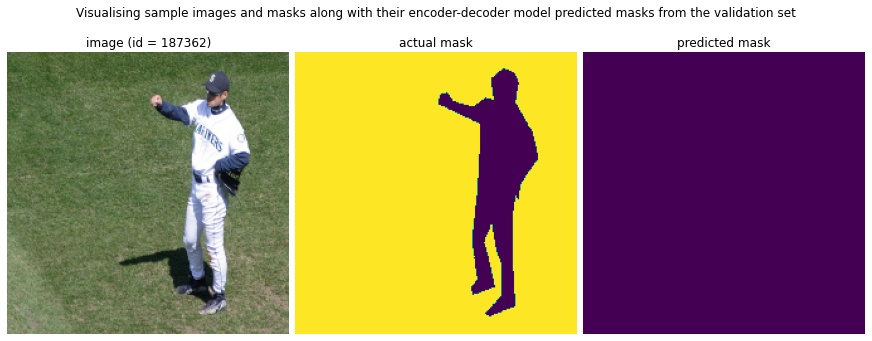

In [101]:
i=0
fig, ax = plt.subplots(1, 3,figsize=(4,4), constrained_layout=True)
fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle(r'Visualising sample images and masks along with their encoder-decoder model predicted masks from the validation set')
ax[0].set_title(f'image (id = {report_val_ids[i]})')
ax[0].axis('off')
ax[0].imshow(val_imgs[i])

ax[1].set_title('actual mask')
ax[1].axis('off')
ax[1].imshow(np.argmax(val_msks[i],axis=2))

ax[2].set_title('predicted mask')
ax[2].axis('off')
ax[2].imshow(np.argmax(preds_encoder_decoder[i],axis=2))
plt.show()

### U-Net Model

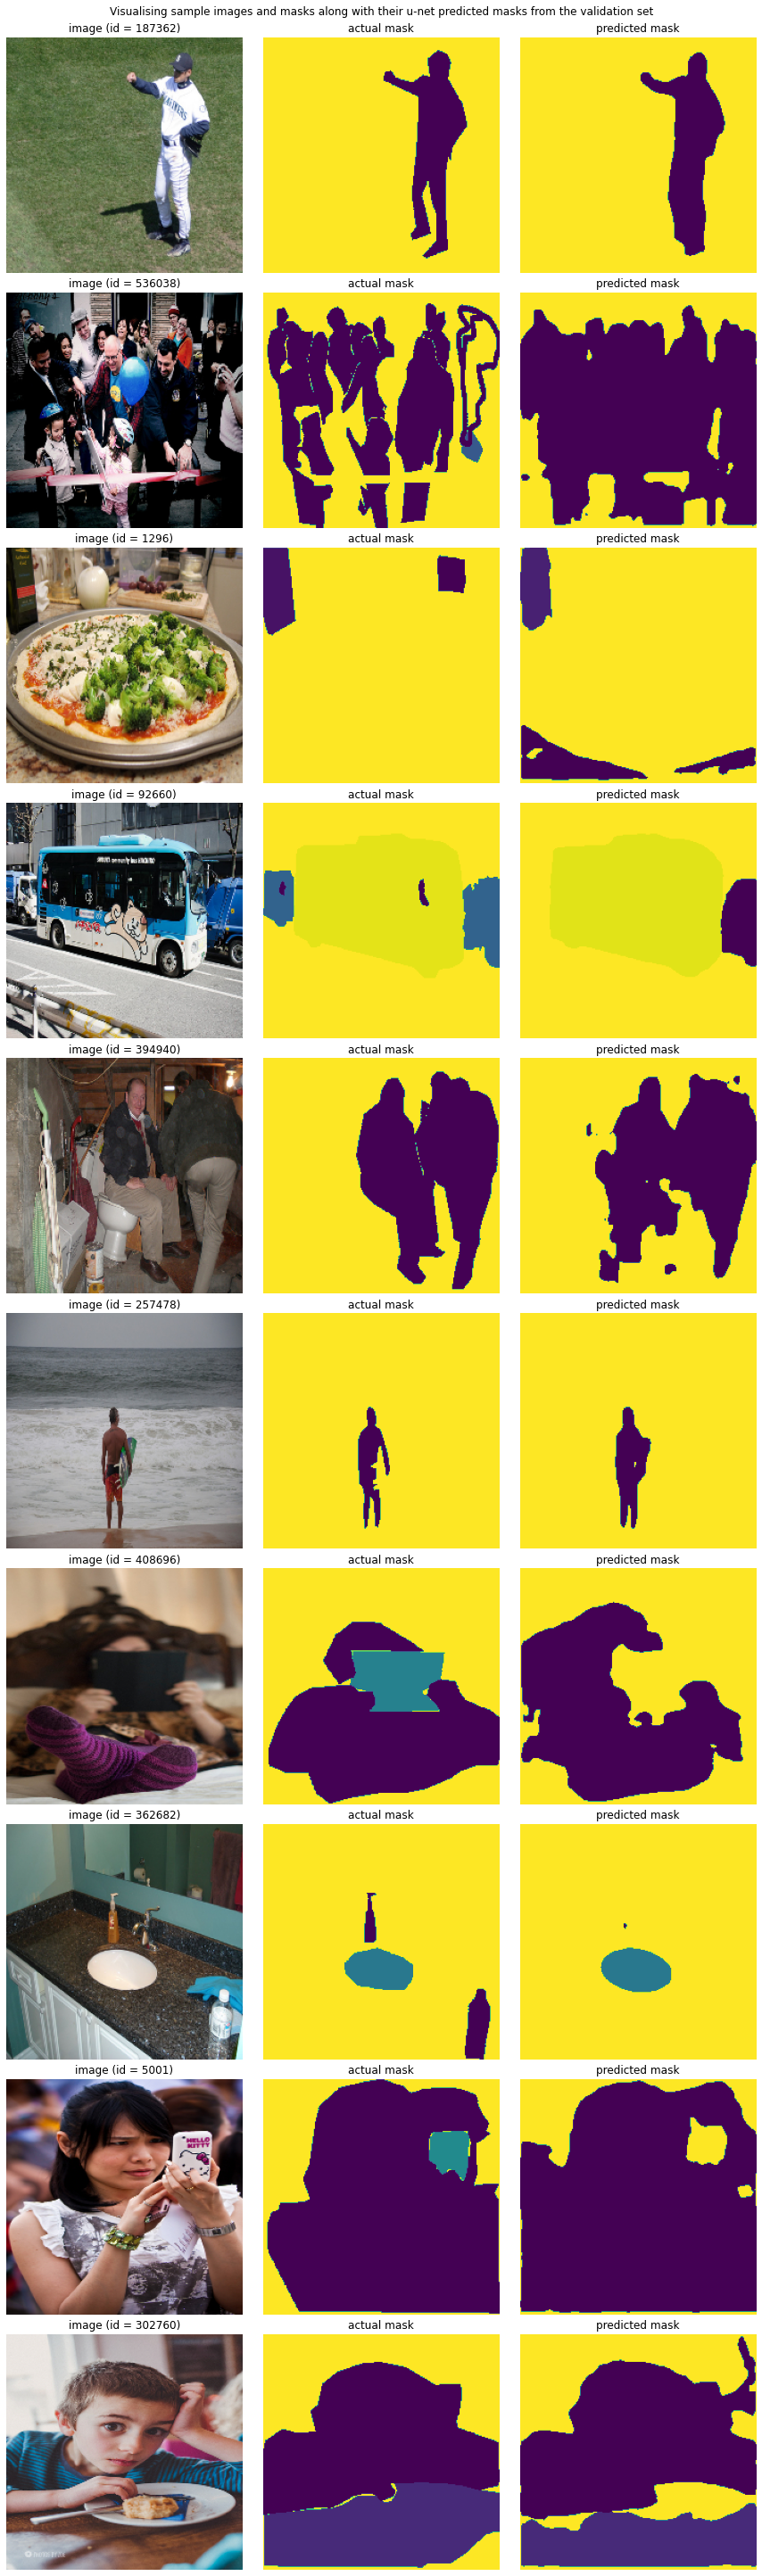

In [93]:
fig, ax = plt.subplots(10, 3,figsize=(4,4), constrained_layout=True)
fig.set_figwidth(12)
fig.set_figheight(40)
fig.suptitle(r'Visualising sample images and masks along with their u-net predicted masks from the validation set')
for i in range(0,10):
    ax[i,0].set_title(f'image (id = {report_val_ids[i]})')
    ax[i,0].axis('off')
    ax[i,0].imshow(val_imgs[i])

    ax[i,1].set_title('actual mask')
    ax[i,1].axis('off')
    ax[i,1].imshow(np.argmax(val_msks[i],axis=2))
    
    ax[i,2].set_title('predicted mask')
    ax[i,2].axis('off')
    ax[i,2].imshow(np.argmax(preds_unet[i],axis=2))
plt.show()

# Conclusion:
The generated masks, while not extremely accurate, are able to achieve results that are comprehensible. Since we only used $60\%$ of our training data, a more accurate result could be achieved with using the entire data and training the network for a longer period of time (if we have not overfitted already). 

Further, I had chosen a batch size of $64$ for training this model since I wanted to speed up the training process as much as possible and $64$ was the highest power of $2$ that would not kill the kaggle runtime environment. Nevertheless, There is a possibility of the model generalizing better on smaller  batch sizes like $32$ or $16$, and could be looked into in the future.

Additionally, since pipelining the data was personally very challenging and we were already using a subset of the data available to us, I did not employ data generation techniques such as data augumentation. Doing so probably might have yielded a more generalizable model and could be looked into in the future as well.